In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
from IPython.display import display, HTML, SVG

In [2]:
from sklearn.metrics import auc, f1_score, precision_recall_curve, roc_curve, accuracy_score, roc_auc_score, average_precision_score, precision_score, recall_score
from sklearn.metrics import auc, precision_recall_curve, roc_curve, confusion_matrix, roc_auc_score, roc_curve, f1_score, accuracy_score
import pandas
import numpy as np
import json
import matplotlib.pyplot as plt
import os
import ast
import seaborn
from sklearn.calibration import calibration_curve
from scipy.stats import binom_test, fisher_exact, chi2_contingency

from db import Result
import math
import papermill as pm
from vis.utils.utils import load_img
from tabulate import tabulate
import svgutils.transform as sg

from config import config
pandas.options.display.float_format = '{:,.3f}'.format

Using TensorFlow backend.
/home/intrepidlemon/.local/share/virtualenvs/deep-ultrasound-eb7oaR1r/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/intrepidlemon/.local/share/virtualenvs/deep-ultrasound-eb7oaR1r/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/intrepidlemon/.local/share/virtualenvs/deep-ultrasound-eb7oaR1r/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be underst

In [3]:
from evaluate import load, get_results, get_labels, adjusted_wald, transform_binary_probabilities, transform_binary_predictions, calculate_accuracy_loss, plot_confusion_matrix, plot_precision_recall, plot_roc_curve, calculate_pr_auc, calculate_confusion_matrix_stats, calculate_confusion_matrix, plot_tsne, accession_from_filename, plot_expert_confusion, plot_grad_cam, get_expert_results, get_pr_data_for_modality, plot_multiple_precision_recall, get_roc_data_for_modality, get_reliability_data_for_modality, plot_multiple_reliability_curve, plot_multiple_roc_curve, get_statistics

In [4]:
from data import describe, all_features, data, print_describe, load_single
from run import characterize_data
from notebook_vars import *

In [5]:
from collections import defaultdict

# Setup -- skip to results below

In [6]:
UUIDS = {
    ("free"): "04cfb42d-3e0b-4516-aa85-56f19cb4d6b9",
    ("fixed"): "cbd87d38-62c5-4196-9c5f-d967eac37085", 
    ("uncertain-free"): "9eecc121-a682-4be8-9aa1-f43f4a8b69a7",
    ("uncertain-fixed"): "fd0391b6-3c63-48d9-a0b4-dc0923f48c32",
}

In [7]:
TRAIN = dict()
VALIDATION = dict()
TEST = dict()

for crop in CROPS: 
    result = Result.query.filter(Result.uuid == UUIDS[crop]).first()
    MODEL = "{}/models/{}-{}.h5".format(config.OUTPUT, result.uuid, result.model)
    model = load(MODEL)
    dataset = load_single("{}/train".format(DATA_FOLDERS[crop]))
    probabilities = get_results(model, dataset)
    predictions = transform_binary_predictions(probabilities)
    labels = get_labels(dataset)
    TRAIN["{}-labels".format(crop)] = labels
    TRAIN["{}-predictions".format(crop)] = predictions
    TRAIN["{}-probabilities".format(crop)] = probabilities
    dataset = load_single("{}/validation".format(DATA_FOLDERS[crop]))
    probabilities = get_results(model, dataset)
    predictions = transform_binary_predictions(probabilities)
    labels = get_labels(dataset)
    VALIDATION["{}-labels".format(crop)] = labels
    VALIDATION["{}-predictions".format(crop)] = predictions
    VALIDATION["{}-probabilities".format(crop)] = probabilities
    dataset = load_single("{}/test".format(DATA_FOLDERS[crop]))
    probabilities = get_results(model, dataset)
    predictions = transform_binary_predictions(probabilities)
    labels = get_labels(dataset)
    TEST["{}-labels".format(crop)] = labels
    TEST["{}-predictions".format(crop)] = predictions
    TEST["{}-probabilities".format(crop)] = probabilities
    # TODO: reset model memory usage
    
COMPLETE_TRAIN = dict()
COMPLETE_VALIDATION = dict()
COMPLETE_TEST = dict()
UNCERTAIN_TRAIN = dict()
UNCERTAIN_VALIDATION = dict()
UNCERTAIN_TEST = dict()

for k, v in TRAIN.items(): 
    if "uncertain" in k: 
        UNCERTAIN_TRAIN[k] = v
    else: 
        COMPLETE_TRAIN[k] = v

for k, v in VALIDATION.items(): 
    if "uncertain" in k: 
        UNCERTAIN_VALIDATION[k] = v
    else: 
        COMPLETE_VALIDATION[k] = v
        
for k, v in TEST.items(): 
    if "uncertain" in k: 
        UNCERTAIN_TEST[k] = v
    else: 
        COMPLETE_TEST[k] = v
        
COMPLETE_MODALITIES = ["free", "fixed"]        
UNCERTAIN_MODALITIES = ["uncertain-free", "uncertain-fixed"]            

Found 660 images belonging to 2 classes.
Found 172 images belonging to 2 classes.
Found 79 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
Found 172 images belonging to 2 classes.
Found 79 images belonging to 2 classes.
Found 314 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 82 images belonging to 2 classes.
Found 314 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 82 images belonging to 2 classes.


In [8]:
f = all_features(features=config.FEATURES, fieldnames=["diagnosis", "malignant", "evidence", "category"])

In [9]:
malignancy = f[1]
category = f[3]

In [10]:
complete = load_single("{}/test".format(DATA_FOLDERS["free"]))
uncertain = load_single("{}/test".format(DATA_FOLDERS["uncertain-free"]))
complete_experts = all_features(features=config.EXPERTS)
uncertain_experts = all_features(features=config.UNCERTAIN_EXPERTS)

Found 79 images belonging to 2 classes.
Found 82 images belonging to 2 classes.


In [11]:
complete_expert_predictions = [list(), list()]
uncertain_expert_predictions = [list(), list()]

complete_data = list()
uncertain_data = list()

for i, n in enumerate(complete.filenames): 
    s = n.split("/")[1].replace("free-", "").replace(".jpeg", "")
    t = s.split("-")[0]
    complete_expert_predictions[0].append(int(complete_experts[0][s]))
    complete_expert_predictions[1].append(int(complete_experts[1][s]))
    complete_data.append({
        "expert 1": int(complete_experts[0][s]), 
        "expert 2": int(complete_experts[1][s]), 
        "free crop": COMPLETE_TEST["free-predictions"][i], 
        "fixed crop":  COMPLETE_TEST["fixed-predictions"][i], 
        "label": 1 if malignancy[t] == "malignant" else 0, 
        "code": category[t], 
    })
    
for i, n in enumerate(uncertain.filenames): 
    s = n.split("/")[1].replace("free-", "").replace(".jpeg", "")
    t = s.split("-")[0]    
    uncertain_expert_predictions[0].append(int(uncertain_experts[0][s]))
    uncertain_expert_predictions[1].append(int(uncertain_experts[1][s]))
    uncertain_data.append({
        "expert 1": int(uncertain_experts[0][s]), 
        "expert 2": int(uncertain_experts[1][s]), 
        "free crop": UNCERTAIN_TEST["uncertain-free-predictions"][i], 
        "fixed crop":  UNCERTAIN_TEST["uncertain-fixed-predictions"][i], 
        "label": 1 if malignancy[t] == "malignant" else 0, 
        "code": category[t], 
    })
complete_pd = pandas.DataFrame(complete_data)
uncertain_pd = pandas.DataFrame(uncertain_data)   

In [12]:
combined_accuracy = list()

for code in complete_pd.code.unique(): 
    current = complete_pd[complete_pd.code == code]
    for crop in ["free crop", "fixed crop"]: 
        combined_accuracy.append({
            "predictor": "ResNet", 
            "code": code, 
            "dataset": "complete set", 
            "crop": crop, 
            "accuracy": accuracy_score(current.label, current[[crop]])
        })
        combined_accuracy.append({
            "predictor": "expert 1", 
            "code": code, 
            "dataset": "complete set", 
            "crop": crop, 
            "accuracy": accuracy_score(current.label, current[["expert 1"]])
        })
        combined_accuracy.append({
            "predictor": "expert 2", 
            "code": code, 
            "dataset": "complete set", 
            "crop": crop, 
            "accuracy": accuracy_score(current.label, current[["expert 2"]])
        })
        
for code in uncertain_pd.code.unique():
    current = uncertain_pd[uncertain_pd.code == code]
    for crop in ["free crop", "fixed crop"]: 
        combined_accuracy.append({
            "predictor": "ResNet", 
            "code": code, 
            "dataset": "uncertain diagnosis set", 
            "crop": crop, 
            "accuracy": accuracy_score(current.label, current[[crop]])
        })
        combined_accuracy.append({
            "predictor": "expert 1", 
            "code": code, 
            "dataset": "uncertain diagnosis set", 
            "crop": crop, 
            "accuracy": accuracy_score(current.label, current[["expert 1"]])
        })
        combined_accuracy.append({
            "predictor": "expert 2", 
            "code": code, 
            "dataset": "uncertain diagnosis set", 
            "crop": crop, 
            "accuracy": accuracy_score(current.label, current[["expert 2"]])
        })
                
combined_accuracy = pandas.DataFrame(combined_accuracy)

In [13]:
df = get_statistics(TEST, experts=[[1 for _ in range(len(TEST["free-labels"]))]])
test_statistics_zero = df
df = get_statistics(UNCERTAIN_TEST, experts=[[1 for _ in range(len(TEST["uncertain-free-labels"]))]], modalities=UNCERTAIN_MODALITIES)
test_statistics_zero_uncertain = df

/home/intrepidlemon/deep-ultrasound/evaluate.py:110: RuntimeWarning: invalid value encountered in true_divide
  PPV = TP / (TP + FP)
/home/intrepidlemon/deep-ultrasound/evaluate.py:112: RuntimeWarning: invalid value encountered in true_divide
  NPV = TN / (TN + FN)
/home/intrepidlemon/deep-ultrasound/evaluate.py:118: RuntimeWarning: invalid value encountered in true_divide
  FDR = FP / (TP + FP)
/home/intrepidlemon/deep-ultrasound/evaluate.py:110: RuntimeWarning: invalid value encountered in true_divide
  PPV = TP / (TP + FP)
/home/intrepidlemon/deep-ultrasound/evaluate.py:112: RuntimeWarning: invalid value encountered in true_divide
  NPV = TN / (TN + FN)
/home/intrepidlemon/deep-ultrasound/evaluate.py:118: RuntimeWarning: invalid value encountered in true_divide
  FDR = FP / (TP + FP)


## Complete test set results

In [14]:
df = get_statistics(COMPLETE_TEST, experts=complete_expert_predictions, modalities=COMPLETE_MODALITIES)
test_statistics = df
df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign", "acc-low", "acc-high"], axis=1)
df

,F1 Score,ROC AUC,PR AUC,PPV,NPV,FDR,Acc (95% CI),TPR (95% CI),TNR (95% CI)
Modality,,,,,,,,,
Free - Complete,0.863,0.828,0.855,0.854,0.806,0.146,0.84 (0.74-0.90),0.87 (0.74-0.94),0.78 (0.61-0.89)
Fixed - Complete,0.843,0.846,0.872,0.782,0.833,0.218,0.80 (0.70-0.87),0.91 (0.80-0.97),0.62 (0.45-0.77)
Expert 1,0.837,nan,nan,0.804,0.786,0.196,0.80 (0.70-0.87),0.87 (0.74-0.94),0.69 (0.51-0.82)
Expert 2,0.784,nan,nan,0.760,0.690,0.240,0.73 (0.63-0.82),0.81 (0.67-0.90),0.62 (0.45-0.77)


## Uncertain test set results

In [15]:
df = get_statistics(UNCERTAIN_TEST, experts=uncertain_expert_predictions, modalities=UNCERTAIN_MODALITIES)
test_statistics_uncertain = df
df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign", "acc-low", "acc-high"], axis=1)
df 

,F1 Score,ROC AUC,PR AUC,PPV,NPV,FDR,Acc (95% CI),TPR (95% CI),TNR (95% CI)
Modality,,,,,,,,,
Free - Uncertain,0.795,0.785,0.745,0.786,0.800,0.214,0.79 (0.69-0.87),0.80 (0.66-0.90),0.78 (0.63-0.88)
Fixed - Uncertain,0.727,0.766,0.768,0.681,0.743,0.319,0.71 (0.60-0.80),0.78 (0.63-0.88),0.63 (0.48-0.76)
Expert 1,0.713,nan,nan,0.674,0.722,0.326,0.70 (0.59-0.78),0.76 (0.60-0.86),0.63 (0.48-0.76)
Expert 2,0.659,nan,nan,0.659,0.659,0.341,0.66 (0.55-0.75),0.66 (0.50-0.79),0.66 (0.50-0.79)


# Model and expert accuracy by code abdomen category

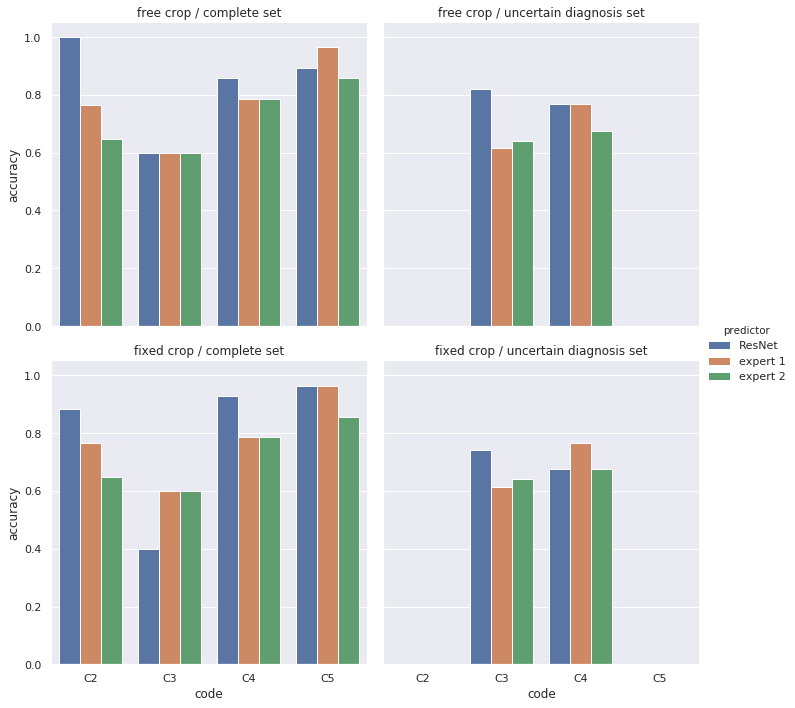

In [16]:
fig = seaborn.catplot(
    x="code", 
    y="accuracy", 
    hue="predictor", 
    row="crop", 
    col="dataset", 
    kind="bar", 
    data=combined_accuracy.sort_values(by=["code", "predictor"])
)
fig.set_titles("{row_name} / {col_name}")

# ROC curves
## Complete set 

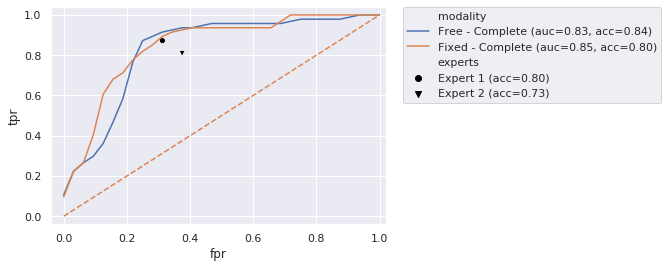

In [17]:
fig = plot_multiple_roc_curve(COMPLETE_TEST,  modalities=COMPLETE_MODALITIES, experts=np.array(complete_expert_predictions))

## Uncertain set

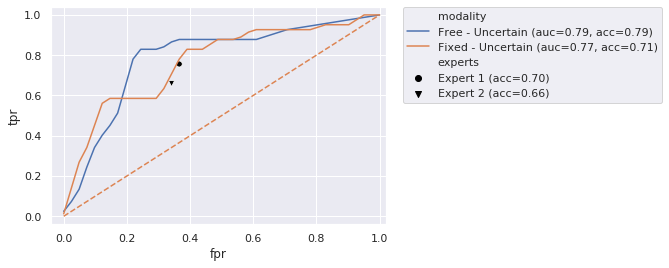

In [18]:
fig = plot_multiple_roc_curve(UNCERTAIN_TEST, modalities=UNCERTAIN_MODALITIES, experts=np.array(uncertain_expert_predictions))

# PR curves
## Complete set 

free 79 79 79
fixed 79 79 79


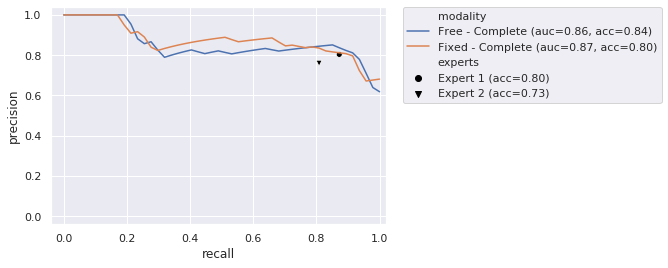

In [19]:
fig = plot_multiple_precision_recall(COMPLETE_TEST,  modalities=COMPLETE_MODALITIES, experts=np.array(complete_expert_predictions))

## Uncertain set

uncertain-free 82 82 82
uncertain-fixed 82 82 82


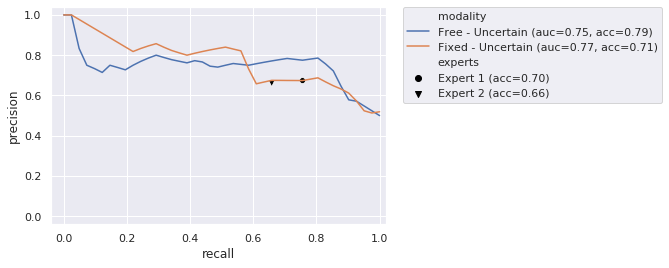

In [20]:
fig = plot_multiple_precision_recall(UNCERTAIN_TEST, modalities=UNCERTAIN_MODALITIES, experts=np.array(uncertain_expert_predictions))

# Confusion matrices

## Test set expert 1

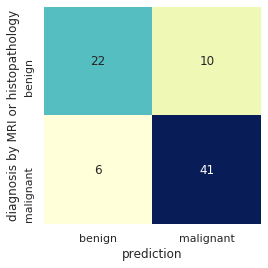

In [21]:
fig = plot_confusion_matrix(complete, np.array(complete_expert_predictions[0]))

## Test set expert 2

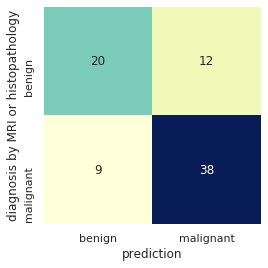

In [22]:
fig = plot_confusion_matrix(complete, np.array(complete_expert_predictions[1]))

## Test set uncertain set expert 1

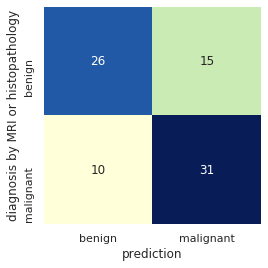

In [23]:
fig = plot_confusion_matrix(uncertain, np.array(uncertain_expert_predictions[0]))

## Test set uncertain set expert 2

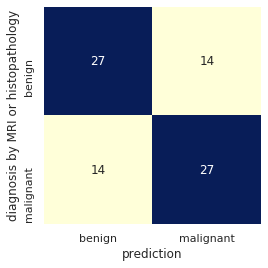

In [24]:
fig = plot_confusion_matrix(uncertain, np.array(uncertain_expert_predictions[1]))

# Train results

In [25]:
df = get_statistics(TRAIN)
df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign", "acc-low", "acc-high"], axis=1)
df

,F1 Score,ROC AUC,PR AUC,PPV,NPV,FDR,Acc (95% CI),TPR (95% CI),TNR (95% CI)
Modality,,,,,,,,,
Free - Complete,0.951,0.991,0.994,0.980,0.904,0.020,0.95 (0.93-0.96),0.92 (0.89-0.95),0.97 (0.95-0.99)
Fixed - Complete,0.933,0.951,0.950,0.884,0.979,0.116,0.92 (0.89-0.94),0.99 (0.97-1.00),0.82 (0.78-0.87)
Free - Uncertain,0.860,0.949,0.962,0.928,0.817,0.072,0.87 (0.82-0.90),0.80 (0.73-0.86),0.93 (0.88-0.97)
Fixed - Uncertain,0.935,0.981,0.978,0.927,0.940,0.073,0.93 (0.90-0.96),0.94 (0.90-0.97),0.92 (0.87-0.96)


# Validation results

In [26]:
df = get_statistics(VALIDATION)
df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign", "acc-low", "acc-high"], axis=1)
df

,F1 Score,ROC AUC,PR AUC,PPV,NPV,FDR,Acc (95% CI),TPR (95% CI),TNR (95% CI)
Modality,,,,,,,,,
Free - Complete,0.879,0.883,0.901,0.887,0.788,0.113,0.85 (0.79-0.90),0.87 (0.79-0.92),0.81 (0.70-0.89)
Fixed - Complete,0.868,0.832,0.886,0.856,0.787,0.144,0.83 (0.77-0.88),0.88 (0.80-0.93),0.75 (0.63-0.84)
Free - Uncertain,0.818,0.846,0.880,0.878,0.718,0.122,0.80 (0.70-0.87),0.77 (0.63-0.87),0.85 (0.69-0.94)
Fixed - Uncertain,0.854,0.845,0.889,0.837,0.806,0.163,0.82 (0.73-0.89),0.87 (0.74-0.94),0.76 (0.59-0.87)
